<a href="https://colab.research.google.com/github/hemalatha0303/Vegetation-Segmentation-using-U-Net-TensorFlow-/blob/main/Vegetation_segmentation_Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install roboflow tensorflow numpy matplotlib scikit-learn opencv-python torchmetrics --upgrade

  Using cached numpy-2.3.5-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)


In [2]:
import os, sys, glob, random, json
from pathlib import Path
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from roboflow import Roboflow
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.20.0


In [3]:
from roboflow import Roboflow
rf = Roboflow(api_key="gloYBKZ871yG0E0geqo4")
project = rf.workspace("blue-halo").project("vegetation-segmentation")
version = project.version(4)
dataset = version.download("yolov11")
print(dataset.location)
dataset_location = Path(dataset.location)

loading Roboflow workspace...
loading Roboflow project...
/content/vegetation-segmentation-4


In [4]:

train_img_dir = dataset_location / "train" / "images"
train_mask_dir = dataset_location / "train" / "masks"
if not train_mask_dir.exists():
    train_mask_dir = dataset_location / "train" / "labels"   # fallback

val_img_dir = dataset_location / "valid" / "images"
val_mask_dir = dataset_location / "valid" / "masks"
if not val_mask_dir.exists():
    val_mask_dir = dataset_location / "valid" / "labels"

print("train images:", train_img_dir.exists(), train_img_dir)
print("train masks :", train_mask_dir.exists(), train_mask_dir)
print("val images  :", val_img_dir.exists(), val_img_dir)
print("val masks   :", val_mask_dir.exists(), val_mask_dir)


train images: True /content/vegetation-segmentation-4/train/images
train masks : True /content/vegetation-segmentation-4/train/labels
val images  : True /content/vegetation-segmentation-4/valid/images
val masks   : True /content/vegetation-segmentation-4/valid/labels


In [5]:
os.makedirs("unet_data/images", exist_ok=True)
os.makedirs("unet_data/masks", exist_ok=True)


In [6]:
def load_yolo_polygon(mask_file, img_h, img_w):
    mask = np.zeros((img_h, img_w), dtype=np.uint8)

    with open(mask_file, "r") as f:
        for line in f.readlines():
            parts = line.strip().split()
            cls = int(parts[0])
            coords = list(map(float, parts[1:]))

            points = np.array(coords).reshape(-1, 2)

            points[:,0] *= img_w
            points[:,1] *= img_h

            points = points.astype(np.int32)

            cv2.fillPoly(mask, [points], 255)

    return mask


In [7]:
image_paths = glob.glob(str(dataset_location) + "/train/images/*")

for img_path in image_paths:
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    h, w = img.shape[:2]

    # Correctly get the base name without the extension
    name = Path(img_path).stem
    mask_path = str(dataset_location) + "/train/labels/" + name + ".txt"

    if not os.path.exists(mask_path):
        continue

    mask = load_yolo_polygon(mask_path, h, w)

    # Normalize + Resize for U-Net
    img_resized = cv2.resize(img, (256, 256)) / 255.0
    mask_resized = cv2.resize(mask, (256, 256), interpolation=cv2.INTER_NEAREST)
    mask_resized = (mask_resized > 0).astype(np.uint8)

    # Save
    cv2.imwrite(f"unet_data/images/{name}.png", (img_resized*255).astype(np.uint8))
    cv2.imwrite(f"unet_data/masks/{name}.png", mask_resized*255)

In [8]:
X = []
y = []

for img_file in sorted(glob.glob("unet_data/images/*.png")):
    mask_file = img_file.replace("images", "masks")

    img = cv2.imread(img_file)
    mask = cv2.imread(mask_file, 0)

    X.append(img / 255.0)
    y.append((mask > 0).astype(np.float32))

X = np.array(X)
y = np.array(y)
y = y.reshape((-1, 256, 256, 1))

X.shape, y.shape

((945, 256, 256, 3), (945, 256, 256, 1))

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_val.shape


((756, 256, 256, 3), (189, 256, 256, 3))

In [10]:
def conv_block(x, filters):
    x = tf.keras.layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    return x

def unet_model():
    inputs = tf.keras.Input((256, 256, 3))

    c1 = conv_block(inputs, 32)
    p1 = tf.keras.layers.MaxPooling2D()(c1)

    c2 = conv_block(p1, 64)
    p2 = tf.keras.layers.MaxPooling2D()(c2)

    c3 = conv_block(p2, 128)
    p3 = tf.keras.layers.MaxPooling2D()(c3)

    c4 = conv_block(p3, 256)
    p4 = tf.keras.layers.MaxPooling2D()(c4)

    c5 = conv_block(p4, 512)

    u6 = tf.keras.layers.UpSampling2D()(c5)
    u6 = tf.keras.layers.Concatenate()([u6, c4])
    c6 = conv_block(u6, 256)

    u7 = tf.keras.layers.UpSampling2D()(c6)
    u7 = tf.keras.layers.Concatenate()([u7, c3])
    c7 = conv_block(u7, 128)

    u8 = tf.keras.layers.UpSampling2D()(c7)
    u8 = tf.keras.layers.Concatenate()([u8, c2])
    c8 = conv_block(u8, 64)

    u9 = tf.keras.layers.UpSampling2D()(c8)
    u9 = tf.keras.layers.Concatenate()([u9, c1])
    c9 = conv_block(u9, 32)

    outputs = tf.keras.layers.Conv2D(1, 1, activation='sigmoid')(c9)

    return tf.keras.Model(inputs, outputs)

model = unet_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        896 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      9,248 │ conv2d[0][0]      │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d_2[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_4[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_6[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_3[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_8[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 32, 32,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ up_sampling2d[0]

 Total params: 7,846,657 (29.93 MB)

 Trainable params: 7,846,657 (29.93 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    batch_size=8,
    epochs=20,
    validation_data=(X_val, y_val)
)


Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 34s 247ms/step - accuracy: 0.8733 - loss: 0.2956 - val_accuracy: 0.8884 - val_loss: 0.2790
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 167ms/step - accuracy: 0.8996 - loss: 0.2558 - val_accuracy: 0.9037 - val_loss: 0.2391
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 168ms/step - accuracy: 0.9127 - loss: 0.2153 - val_accuracy: 0.9116 - val_loss: 0.2243
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 164ms/step - accuracy: 0.9192 - loss: 0.2045 - val_accuracy: 0.9220 - val_loss: 0.1973
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 15s 162ms/step - accuracy: 0.9223 - loss: 0.1947 - val_accuracy: 0.9194 - val_loss: 0.2020
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 15s 163ms/step - accuracy: 0.9266 - loss: 0.1861 - val_accuracy: 0.9279 - val_loss: 0.1887
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 163ms/step - accuracy: 0.9267 - loss: 0.1911 - val_accuracy: 0.9000 - val_loss: 0.2500
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 165ms/step - accuracy: 0.9197 - loss: 0.1987 - val_accu

In [23]:
preds = model.predict(X_val)
preds_bin = (preds > 0.5).astype(np.uint8)

# Convert to torch tensors
preds_t = torch.tensor(preds_bin.squeeze()).long()
labels_t = torch.tensor(y_val.squeeze()).long()

# Dice Score - calculating manually , imports are not working
def dice_score(pred, target, smooth=1e-6):
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)

    intersection = (pred_flat * target_flat).sum()
    return (2. * intersection + smooth) / (pred_flat.sum() + target_flat.sum() + smooth)

# IoU Score - calculating manually , imports are not working
def iou_score(pred, target, smooth=1e-6):
    pred_flat = pred.view(-1)
    target_flat = target.view(-1)

    intersection = (pred_flat * target_flat).sum()
    union = pred_flat.sum() + target_flat.sum() - intersection

    return (intersection + smooth) / (union + smooth)

# metric
dice = dice_score(preds_t, labels_t)
iou = iou_score(preds_t, labels_t)

print("Dice Score:", float(dice))
print("IoU Score:", float(iou))

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step
Dice Score: 0.9355144500732422
IoU Score: 0.8788418769836426


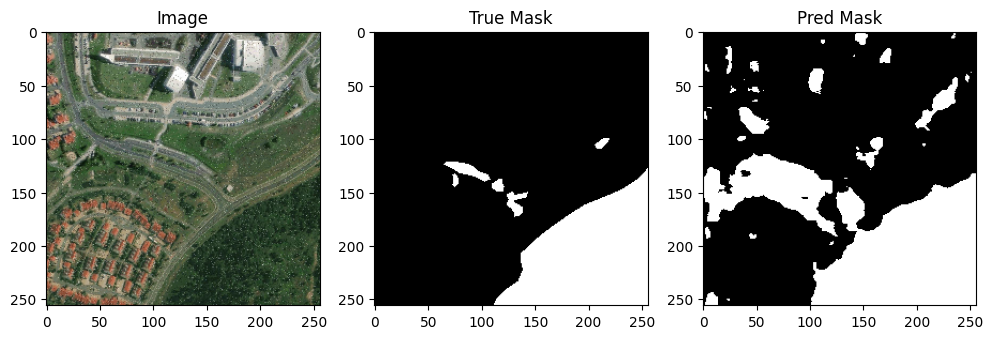

In [29]:
i = 0
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Image"); plt.imshow(X_val[i])
plt.subplot(1,3,2); plt.title("True Mask"); plt.imshow(y_val[i].squeeze(), cmap='gray')
plt.subplot(1,3,3); plt.title("Pred Mask"); plt.imshow(preds_bin[i].squeeze(), cmap='gray')
plt.show()


In [32]:
model.save('unet_vegetation_segmentation_model.keras')

In [34]:
from google.colab import files

files.download('unet_vegetation_segmentation_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The model has been saved as `unet_vegetation_segmentation_model.keras` in your Colab environment. You can download it if needed.